In [1]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [2]:
# https://mp.weixin.qq.com/s/b-h1pNt5LFgy0UKVsfltNQ
# https://mp.weixin.qq.com/s?__biz=MzUxNjcxMjQxNg==&mid=2247490717&idx=5&sn=ed7377461ec54365e6cc4da452bd5548&scene=21#wechat_redirect

In [84]:
import sys
!{sys.executable} -m pip install seaborn

     |████████████████████████████████| 215kB 9.5MB/s eta 0:00:01


In [4]:
from pytorch_geometric2 import *

In [5]:
from tqdm import tqdm

In [6]:
import os
import pandas as pd
import networkx as nx

import pandas as pd
import numpy as np
import os

from sklearn import preprocessing
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig


pd.set_option('display.max_columns', 500)

In [7]:
file_folder = '../../data/input'
os.listdir(file_folder)

['test.csv',
 'structures',
 'sample_submission.csv',
 'magnetic_shielding_tensors.csv',
 'mulliken_charges.csv',
 'potential_energy.csv',
 'scalar_coupling_contributions.csv',
 'dipole_moments.csv',
 'structures.csv',
 'train.csv']

In [37]:
# sch_csv_folder = '../../data/temp/mpnn_keras'
# [csv for csv in os.listdir(sch_csv_folder) if 'log' in csv]

In [38]:
# df_log_omega = pd.read_csv(f'{sch_csv_folder}/log_omega.csv')

In [39]:
# print(df_log_omega.shape)
# df_log_omega.head()

In [63]:
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
magnetic_shielding_tensors = pd.read_csv(f'{file_folder}/magnetic_shielding_tensors.csv')
dipole_moments = pd.read_csv(f'{file_folder}/dipole_moments.csv')
mulliken_charges = pd.read_csv(f'{file_folder}/mulliken_charges.csv')
potential_energy = pd.read_csv(f'{file_folder}/potential_energy.csv')
scalar_coupling_contributions = pd.read_csv(f'{file_folder}/scalar_coupling_contributions.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')

In [13]:
def load_csv(DATA_DIR):

#     DATA_DIR = '/root/share/project/kaggle/2019/champs_scalar/data'

    #structure
    df_structure = pd.read_csv(DATA_DIR + '/structures.csv')

    #coupling
    df_train = pd.read_csv(DATA_DIR + '/train.csv')
    df_test  = pd.read_csv(DATA_DIR + '/test.csv')
    df_test['scalar_coupling_constant']=0
    df_scalar_coupling = pd.concat([df_train,df_test])
    df_scalar_coupling_contribution = pd.read_csv(DATA_DIR + '/scalar_coupling_contributions.csv')
    df_scalar_coupling = pd.merge(df_scalar_coupling, df_scalar_coupling_contribution, how='left', on=['molecule_name','atom_index_0','atom_index_1','atom_index_0','type'])
    gb_scalar_coupling = df_scalar_coupling.groupby('molecule_name')
    gb_structure       = df_structure.groupby('molecule_name')

    return gb_structure, gb_scalar_coupling

##
# Written by Jan H. Jensen based on this paper Yeonjoon Kim and Woo Youn Kim 
# "Universal Structure Conversion Method for Organic Molecules: From Atomic Connectivity
# to Three-Dimensional Geometry" Bull. Korean Chem. Soc. 2015, Vol. 36, 1769-1777 DOI: 10.1002/bkcs.10334
#
from rdkit import Chem
from rdkit.Chem import AllChem
import itertools
from rdkit.Chem import rdmolops
from collections import defaultdict
import copy
import networkx as nx #uncomment if you don't want to use "quick"/install networkx


global __ATOM_LIST__
__ATOM_LIST__ = [ x.strip() for x in ['h ','he', \
      'li','be','b ','c ','n ','o ','f ','ne', \
      'na','mg','al','si','p ','s ','cl','ar', \
      'k ','ca','sc','ti','v ','cr','mn','fe','co','ni','cu', \
      'zn','ga','ge','as','se','br','kr', \
      'rb','sr','y ','zr','nb','mo','tc','ru','rh','pd','ag', \
      'cd','in','sn','sb','te','i ','xe', \
      'cs','ba','la','ce','pr','nd','pm','sm','eu','gd','tb','dy', \
      'ho','er','tm','yb','lu','hf','ta','w ','re','os','ir','pt', \
      'au','hg','tl','pb','bi','po','at','rn', \
      'fr','ra','ac','th','pa','u ','np','pu'] ]


def get_atom(atom):
    global __ATOM_LIST__
    atom = atom.lower()
    return __ATOM_LIST__.index(atom) + 1


def getUA(maxValence_list, valence_list):
    UA = []
    DU = []
    for i, (maxValence,valence) in enumerate(zip(maxValence_list, valence_list)):
        if maxValence - valence > 0:
            UA.append(i)
            DU.append(maxValence - valence)
    return UA,DU


def get_BO(AC,UA,DU,valences,UA_pairs,quick):
    BO = AC.copy()
    DU_save = []

    while DU_save != DU:
        for i,j in UA_pairs:
            BO[i,j] += 1
            BO[j,i] += 1 
        
        BO_valence = list(BO.sum(axis=1))
        DU_save = copy.copy(DU)
        UA, DU = getUA(valences, BO_valence)
        UA_pairs = get_UA_pairs(UA,AC,quick)[0]

    return BO


def valences_not_too_large(BO,valences):
    number_of_bonds_list = BO.sum(axis=1)
    for valence, number_of_bonds in zip(valences,number_of_bonds_list):
        if number_of_bonds > valence:
            return False

    return True


def BO_is_OK(BO,AC,charge,DU,atomic_valence_electrons,atomicNumList,charged_fragments):
    Q = 0 # total charge
    q_list = []
    if charged_fragments:
        BO_valences = list(BO.sum(axis=1))
        for i,atom in enumerate(atomicNumList):
            q = get_atomic_charge(atom,atomic_valence_electrons[atom],BO_valences[i])
            Q += q
            if atom == 6:
                number_of_single_bonds_to_C = list(BO[i,:]).count(1)
                if number_of_single_bonds_to_C == 2 and BO_valences[i] == 2:
                    Q += 1
                    q = 2
                if number_of_single_bonds_to_C == 3 and Q + 1 < charge:
                    Q += 2
                    q = 1
            
            if q != 0:
                q_list.append(q)

    if (BO-AC).sum() == sum(DU) and charge == Q and len(q_list) <= abs(charge):
        return True
    else:
        return False


def get_atomic_charge(atom,atomic_valence_electrons,BO_valence):
    if atom == 1:
        charge = 1 - BO_valence
    elif atom == 5:
        charge = 3 - BO_valence
    elif atom == 15 and BO_valence == 5:
        charge = 0
    elif atom == 16 and BO_valence == 6:
        charge = 0
    else:
        charge = atomic_valence_electrons - 8 + BO_valence

    return charge

def clean_charges(mol):
# this hack should not be needed any more but is kept just in case
#

    rxn_smarts = ['[N+:1]=[*:2]-[C-:3]>>[N+0:1]-[*:2]=[C-0:3]',
                  '[N+:1]=[*:2]-[O-:3]>>[N+0:1]-[*:2]=[O-0:3]',
                  '[N+:1]=[*:2]-[*:3]=[*:4]-[O-:5]>>[N+0:1]-[*:2]=[*:3]-[*:4]=[O-0:5]',
                  '[#8:1]=[#6:2]([!-:6])[*:3]=[*:4][#6-:5]>>[*-:1][*:2]([*:6])=[*:3][*:4]=[*+0:5]',
                  '[O:1]=[c:2][c-:3]>>[*-:1][*:2][*+0:3]',
                  '[O:1]=[C:2][C-:3]>>[*-:1][*:2]=[*+0:3]']

    fragments = Chem.GetMolFrags(mol,asMols=True,sanitizeFrags=False)

    for i,fragment in enumerate(fragments):
        for smarts in rxn_smarts:
            patt = Chem.MolFromSmarts(smarts.split(">>")[0])
            while fragment.HasSubstructMatch(patt):
                rxn = AllChem.ReactionFromSmarts(smarts)
                ps = rxn.RunReactants((fragment,))
                fragment = ps[0][0]
        if i == 0:
            mol = fragment
        else:
            mol = Chem.CombineMols(mol,fragment)

    return mol


def BO2mol(mol,BO_matrix, atomicNumList,atomic_valence_electrons,mol_charge,charged_fragments):
# based on code written by Paolo Toscani

    l = len(BO_matrix)
    l2 = len(atomicNumList)
    BO_valences = list(BO_matrix.sum(axis=1))

    if (l != l2):
        raise RuntimeError('sizes of adjMat ({0:d}) and atomicNumList '
            '{1:d} differ'.format(l, l2))

    rwMol = Chem.RWMol(mol)

    bondTypeDict = {
        1: Chem.BondType.SINGLE,
        2: Chem.BondType.DOUBLE,
        3: Chem.BondType.TRIPLE
    }

    for i in range(l):
        for j in range(i + 1, l):
            bo = int(round(BO_matrix[i, j]))
            if (bo == 0):
                continue
            bt = bondTypeDict.get(bo, Chem.BondType.SINGLE)
            rwMol.AddBond(i, j, bt)
    mol = rwMol.GetMol()

    if charged_fragments:
        mol = set_atomic_charges(mol,atomicNumList,atomic_valence_electrons,BO_valences,BO_matrix,mol_charge)
    else:
        mol = set_atomic_radicals(mol,atomicNumList,atomic_valence_electrons,BO_valences)

    return mol

def set_atomic_charges(mol,atomicNumList,atomic_valence_electrons,BO_valences,BO_matrix,mol_charge):
    q = 0
    for i,atom in enumerate(atomicNumList):
        a = mol.GetAtomWithIdx(i)
        charge = get_atomic_charge(atom,atomic_valence_electrons[atom],BO_valences[i])
        q += charge
        if atom == 6:
            number_of_single_bonds_to_C = list(BO_matrix[i,:]).count(1)
            if number_of_single_bonds_to_C == 2 and BO_valences[i] == 2:
                    q += 1
                    charge = 0
            if number_of_single_bonds_to_C == 3 and q + 1 < mol_charge:
                    q += 2
                    charge = 1

        if (abs(charge) > 0):
            a.SetFormalCharge(int(charge))

    # shouldn't be needed anymore bit is kept just in case
    #mol = clean_charges(mol)

    return mol


def set_atomic_radicals(mol,atomicNumList,atomic_valence_electrons,BO_valences):
# The number of radical electrons = absolute atomic charge
    for i,atom in enumerate(atomicNumList):
        a = mol.GetAtomWithIdx(i)
        charge = get_atomic_charge(atom,atomic_valence_electrons[atom],BO_valences[i])

        if (abs(charge) > 0):
            a.SetNumRadicalElectrons(abs(int(charge)))

    return mol

def get_bonds(UA,AC):
    bonds = []

    for k,i in enumerate(UA):
        for j in UA[k+1:]:
            if AC[i,j] == 1:
                bonds.append(tuple(sorted([i,j])))

    return bonds

def get_UA_pairs(UA,AC,quick):
    bonds = get_bonds(UA,AC)
    if len(bonds) == 0:
        return [()]

    if quick:
        G=nx.Graph()
        G.add_edges_from(bonds)
        UA_pairs = [list(nx.max_weight_matching(G))]
        return UA_pairs

    max_atoms_in_combo = 0
    UA_pairs = [()]
    for combo in list(itertools.combinations(bonds, int(len(UA)/2))):
        flat_list = [item for sublist in combo for item in sublist]
        atoms_in_combo = len(set(flat_list))
        if atoms_in_combo > max_atoms_in_combo:
            max_atoms_in_combo = atoms_in_combo
            UA_pairs = [combo]
 #           if quick and max_atoms_in_combo == 2*int(len(UA)/2):
 #               return UA_pairs
        elif atoms_in_combo == max_atoms_in_combo:
            UA_pairs.append(combo)

    return UA_pairs

def AC2BO(AC,atomicNumList,charge,charged_fragments,quick):
    # TODO
    atomic_valence = defaultdict(list)
    atomic_valence[1] = [1]
    atomic_valence[6] = [4]
    atomic_valence[7] = [4,3]
    atomic_valence[8] = [2,1]
    atomic_valence[9] = [1]
    atomic_valence[14] = [4]
    atomic_valence[15] = [5,4,3]
    atomic_valence[16] = [6,4,2]
    atomic_valence[17] = [1]
    atomic_valence[32] = [4]
    atomic_valence[35] = [1]
    atomic_valence[53] = [1]


    atomic_valence_electrons = {}
    atomic_valence_electrons[1] = 1
    atomic_valence_electrons[6] = 4
    atomic_valence_electrons[7] = 5
    atomic_valence_electrons[8] = 6
    atomic_valence_electrons[9] = 7
    atomic_valence_electrons[14] = 4
    atomic_valence_electrons[15] = 5
    atomic_valence_electrons[16] = 6
    atomic_valence_electrons[17] = 7
    atomic_valence_electrons[32] = 4
    atomic_valence_electrons[35] = 7
    atomic_valence_electrons[53] = 7

# make a list of valences, e.g. for CO: [[4],[2,1]]
    valences_list_of_lists = []
    for atomicNum in atomicNumList:
        valences_list_of_lists.append(atomic_valence[atomicNum])

# convert [[4],[2,1]] to [[4,2],[4,1]]
    valences_list = itertools.product(*valences_list_of_lists)

    best_BO = AC.copy()

# implemenation of algorithm shown in Figure 2
# UA: unsaturated atoms
# DU: degree of unsaturation (u matrix in Figure)
# best_BO: Bcurr in Figure 
#

    for valences in valences_list:
        AC_valence = list(AC.sum(axis=1))
        UA,DU_from_AC = getUA(valences, AC_valence)

        if len(UA) == 0 and BO_is_OK(AC,AC,charge,DU_from_AC,atomic_valence_electrons,atomicNumList,charged_fragments):
            return AC,atomic_valence_electrons
        
        UA_pairs_list = get_UA_pairs(UA,AC,quick) 
        for UA_pairs in UA_pairs_list:
            BO = get_BO(AC,UA,DU_from_AC,valences,UA_pairs,quick)
            if BO_is_OK(BO,AC,charge,DU_from_AC,atomic_valence_electrons,atomicNumList,charged_fragments):
                return BO,atomic_valence_electrons

            elif BO.sum() >= best_BO.sum() and valences_not_too_large(BO,valences):
                best_BO = BO.copy()

    return best_BO,atomic_valence_electrons


def AC2mol(mol,AC,atomicNumList,charge,charged_fragments,quick):
# convert AC matrix to bond order (BO) matrix
    BO,atomic_valence_electrons = AC2BO(AC,atomicNumList,charge,charged_fragments,quick)

# add BO connectivity and charge info to mol object
    mol = BO2mol(mol,BO, atomicNumList,atomic_valence_electrons,charge,charged_fragments)

    return mol


def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#"+str(atomicNumList[0])+"]")
    rwMol = Chem.RWMol(mol)
    for i in range(1,len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)
    
    mol = rwMol.GetMol()

    return mol


def get_atomicNumList(atomic_symbols):
    atomicNumList = []
    for symbol in atomic_symbols:
        atomicNumList.append(get_atom(symbol))
    return atomicNumList


def read_xyz_file(filename):

    atomic_symbols = []
    xyz_coordinates = []

    with open(filename, "r") as file:
        for line_number,line in enumerate(file):
            if line_number == 0:
                num_atoms = int(line)
            elif line_number == 1:
                if "charge=" in line:
                    charge = int(line.split("=")[1])
                else:
                    charge = 0
            else:
                atomic_symbol, x, y, z = line.split()
                atomic_symbols.append(atomic_symbol)
                xyz_coordinates.append([float(x),float(y),float(z)])

    atomicNumList = get_atomicNumList(atomic_symbols)
    
    return atomicNumList,charge,xyz_coordinates

def xyz2AC(atomicNumList,xyz):
    import numpy as np
    mol = get_proto_mol(atomicNumList)
    conf = Chem.Conformer(mol.GetNumAtoms())
#     print(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i,(xyz[i][0],xyz[i][1],xyz[i][2]))
    mol.AddConformer(conf)

    dMat = Chem.Get3DDistanceMatrix(mol)
    pt = Chem.GetPeriodicTable()

    num_atoms = len(atomicNumList)
    AC = np.zeros((num_atoms,num_atoms)).astype(int)

    for i in range(num_atoms):
        a_i = mol.GetAtomWithIdx(i)
        Rcov_i = pt.GetRcovalent(a_i.GetAtomicNum())*1.30
        for j in range(i+1,num_atoms):
            a_j = mol.GetAtomWithIdx(j)
            Rcov_j = pt.GetRcovalent(a_j.GetAtomicNum())*1.30
            if dMat[i,j] <= Rcov_i + Rcov_j:
                AC[i,j] = 1
                AC[j,i] = 1

    return AC,mol

def chiral_stereo_check(mol):
    Chem.SanitizeMol(mol)
    Chem.DetectBondStereochemistry(mol,-1)
    Chem.AssignStereochemistry(mol, flagPossibleStereoCenters=True, force=True)
    Chem.AssignAtomChiralTagsFromStructure(mol,-1)

    return mol

def xyz2mol(atomicNumList,charge,xyz_coordinates,charged_fragments,quick):

# Get atom connectivity (AC) matrix, list of atomic numbers, molecular charge, 
# and mol object with no connectivity information
    AC,mol = xyz2AC(atomicNumList,xyz_coordinates)

# Convert AC to bond order matrix and add connectivity and charge info to mol object
    new_mol = AC2mol(mol,AC,atomicNumList,charge,charged_fragments,quick)

# Check for stereocenters and chiral centers
    new_mol = chiral_stereo_check(new_mol)

    return new_mol

# if __name__ == "__main__":

#     import argparse

#     parser = argparse.ArgumentParser(usage='%(prog)s [options] molecule.xyz')
#     parser.add_argument('structure', metavar='structure', type=str)
#     parser.add_argument('-s', '--sdf', action="store_true", help="Dump sdf file")
#     args = parser.parse_args()

    
#     filename = args.structure
#     charged_fragments = True # alternatively radicals are made

#     # quick is faster for large systems but requires networkx
#     # if you don't want to install networkx set quick=False and 
#     # uncomment 'import networkx as nx' at the top of the file 
#     quick = True 

#     atomicNumList, charge, xyz_coordinates = read_xyz_file(filename)

#     mol = xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments, quick)

#     if args.sdf:
#         filename = filename.replace(".xyz", "")
#         filename += ".sdf"
#         writer = Chem.SDWriter(filename)
#         writer.write(mol)

#     # Canonical hack
#     smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
#     m = Chem.MolFromSmiles(smiles)
#     smiles = Chem.MolToSmiles(m, isomericSmiles=True)

#     print(smiles)

In [25]:
import community

# def xyz_df2mol(g):
#     atomic_symbols   = g.atom.values.tolist()
#     atomicNumList = get_atomicNumList(atomic_symbols)
#     xyz = g[['x','y','z']].values
#     charge  = 0
#     charged_fragments = True
#     quick   =  True
#     mol = xyz2mol(atomicNumList, charge, xyz, charged_fragments, quick)
#     return mol

def mol2nx(mol):
    G = nx.Graph()
    G.add_nodes_from([a.GetIdx() for a in mol.GetAtoms()])
    G.add_edges_from([(b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol.GetBonds()])
    return G

In [15]:
gb_structure, gb_scalar_coupling = load_csv(file_folder)

In [ ]:
# longest_atom_counts = 0

for (structure_c, structure_g), (bond_c, bond_g) in tqdm(zip(gb_structure, gb_scalar_coupling), total=len(gb_structure)):
    a   = structure_g.atom.values.tolist()
    xyz = structure_g[['x','y','z']].values
    mol = mol_from_axyz(a, xyz)
    G = mol2nx(mol)
    
    shortest_path = dict(nx.all_pairs_shortest_path_length(G))
    
    partition = community.best_partition(G)
    
    centrality = nx.pagerank(G, alpha=0.75)
    
    c_degree = nx.degree_centrality(G)
    c_degree = list(c_degree.values())
    
    c_eigenvector = nx.eigenvector_centrality(G, max_iter=500)
    c_eigenvector = list(c_eigenvector.values())
    
    c_closeness = nx.closeness_centrality(G)
    c_closeness = list(c_closeness.values())
    
    c_betweenness = nx.betweenness_centrality(G)
    c_betweenness = list(c_betweenness.values())
    
    df_mol_i = pd.DataFrame({'molecule_name':bond_c, 
                             'atom_index':list(shortest_path.keys()), 
                             'community':list(partition.values()),
                             'centrality':list(centrality.values()),
                             'c_degree':c_degree,
                             'c_eigenvector':c_eigenvector,
                             'c_closeness':c_closeness,
                            })
    shortest_path_df = pd.DataFrame(shortest_path.values())
    shortest_path_df.columns = [f'gdist_to{atom_i}' for atom_i in range(shortest_path_df.shape[0])]
    df_mol_i = pd.concat([df_mol_i, shortest_path_df], axis=1)
    
#     'shortest_path':list(shortest_path.values())
    
    df_mol = pd.concat([df_mol, df_mol_i], axis=0)
    
    
#     break

  0%|          | 1/130775 [00:00<19:01:20,  1.91it/s]/root/anaconda3/envs/wang/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

 27%|██▋       | 35405/130775 [32:57<2:27:56, 10.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 91%|█████████ | 119202/130775 [7:02:14<1:42:05,  1.89it/s]

In [35]:
df_mol.molecule_name.unique().shape

(130775,)

In [36]:
df_mol.columns

Index(['atom_index', 'c_closeness', 'c_degree', 'c_eigenvector', 'centrality',
       'community', 'gdist_to0', 'gdist_to1', 'gdist_to10', 'gdist_to11',
       'gdist_to12', 'gdist_to13', 'gdist_to14', 'gdist_to15', 'gdist_to16',
       'gdist_to17', 'gdist_to18', 'gdist_to19', 'gdist_to2', 'gdist_to20',
       'gdist_to21', 'gdist_to22', 'gdist_to23', 'gdist_to24', 'gdist_to25',
       'gdist_to26', 'gdist_to27', 'gdist_to28', 'gdist_to3', 'gdist_to4',
       'gdist_to5', 'gdist_to6', 'gdist_to7', 'gdist_to8', 'gdist_to9',
       'molecule_name'],
      dtype='object')

In [41]:
print(structures.shape, df_mol.shape)
structures.head()

(2358657, 6) (2358657, 36)


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [64]:
df_atom_prop = pd.DataFrame()
df_atom_prop['atom']= list(electronegativity.keys())

In [65]:
atom_prop_dict = {'electronegativity':electronegativity, 
                  'charge':charge, 
                  'etat':etat, 
                  'masse':masse, 
                  'volume':volume, 
                  'rayon_am':rayon_am, 
                  'rayon_ac':rayon_ac, 
                  'rayon_c':rayon_c, 
                  'rayon_i':rayon_i, 
                  'rayon_vdw':rayon_vdw, 
                  'fusion':fusion, 
                  'ebulution_min':ebulution_min, 
                  'enthalpie_fusion':enthalpie_fusion, 
                  'enthalpie_vaporisation':enthalpie_vaporisation, 
                  'capacite_thermique':capacite_thermique, 
                  'conductivite_thermique':conductivite_thermique, 
                  'isotopes':isotopes, 
                  'isotopes_emeteurs':isotopes_emeteurs}

In [66]:
for prop_name, prop in atom_prop_dict.items():
    if list(prop.keys())== df_atom_prop['atom'].tolist():
        df_atom_prop[prop_name] = prop.values()
    else:
        print(prop_name, 'atom is not same order')

In [67]:
df_atom_prop

,atom,electronegativity,charge,etat,masse,volume,rayon_am,rayon_ac,rayon_c,rayon_i,rayon_vdw,fusion,ebulution_min,enthalpie_fusion,enthalpie_vaporisation,capacite_thermique,conductivite_thermique,isotopes,isotopes_emeteurs
0,H,2.20,0.00,0.00,76.00,13.26,25.00,53.00,38.00,-3.00,120.00,-259.10,-252.90,0.12,0.46,14.30,0.18,3.00,0.00
1,C,2.55,1.00,1.00,3513.00,3.42,70.00,67.00,77.00,4.00,170.00,3546.90,4826.90,105.00,710.90,0.71,990.00,12.00,3.00
2,N,3.04,1.00,0.00,1026.00,13.65,65.00,56.00,75.00,-3.00,155.00,-209.90,-195.80,0.72,5.58,1.04,0.03,12.00,3.00
3,O,3.44,3.44,3.44,3.44,3.44,3.44,0.73,3.44,3.44,3.44,3.44,3.44,3.44,3.44,3.44,3.44,3.44,3.44
4,F,3.98,3.98,3.98,3.98,3.98,3.98,0.71,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98


In [68]:
structures = pd.merge(structures, df_atom_prop, how='left',on='atom')

In [69]:
structures.head()

,molecule_name,atom_index,atom,x,y,z,electronegativity,charge,etat,masse,volume,rayon_am,rayon_ac,rayon_c,rayon_i,rayon_vdw,fusion,ebulution_min,enthalpie_fusion,enthalpie_vaporisation,capacite_thermique,conductivite_thermique,isotopes,isotopes_emeteurs
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,2.55,1.0,1.0,3513.0,3.42,70.0,67.0,77.0,4.0,170.0,3546.9,4826.9,105.00,710.90,0.71,990.00,12.0,3.0
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,2.20,0.0,0.0,76.0,13.26,25.0,53.0,38.0,-3.0,120.0,-259.1,-252.9,0.12,0.46,14.30,0.18,3.0,0.0
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,2.20,0.0,0.0,76.0,13.26,25.0,53.0,38.0,-3.0,120.0,-259.1,-252.9,0.12,0.46,14.30,0.18,3.0,0.0
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,2.20,0.0,0.0,76.0,13.26,25.0,53.0,38.0,-3.0,120.0,-259.1,-252.9,0.12,0.46,14.30,0.18,3.0,0.0
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,2.20,0.0,0.0,76.0,13.26,25.0,53.0,38.0,-3.0,120.0,-259.1,-252.9,0.12,0.46,14.30,0.18,3.0,0.0


In [43]:
####Chemical properties
#electronegativity pauling
electronegativity = {'H':2.2, 'C':2.55, 'N':3.04 , 'O':3.44, 'F':3.98 }
#Type de charge 
charge ={'H':0, 'C':1, 'N':1 , 'O':3.44, 'F':3.98 }
#etat
etat ={'H':0, 'C':1, 'N':0, 'O':3.44, 'F':3.98 }
#Masse kg/m^3
masse = {'H':76, 'C':3513, 'N':1026, 'O':3.44, 'F':3.98 }
#volume cm^3/mole
volume = {'H':13.26, 'C':3.42, 'N':13.65, 'O':3.44, 'F':3.98 }
#Rayon atomique (mesuré)
rayon_am = {'H':25, 'C':70, 'N':65, 'O':3.44, 'F':3.98 }
#Rayon atomique (calculé)
rayon_ac = {'H':53, 'C':67, 'N':56 ,'O':0.73, 'F':0.71}
#Rayon covalent
rayon_c = {'H':38, 'C':77, 'N':75, 'O':3.44, 'F':3.98 }
#Rayon ionique
rayon_i = {'H':-3, 'C':4, 'N':-3, 'O':3.44, 'F':3.98 }
#Rayon de Van der Waals
rayon_vdw = {'H':120, 'C':170, 'N':155, 'O':3.44, 'F':3.98 }

#### Physical properties
#Point de fusion
fusion = {'H':-259.1, 'C':3546.9, 'N':-209.9, 'O':3.44, 'F':3.98 }
#seuil d'ébulution minimal (celcius)
ebulution_min = {'H':-252.9, 'C':4826.9, 'N':-195.8, 'O':3.44, 'F':3.98 }
#Enthalpie de fusion ΔHf (kj/mol)
enthalpie_fusion = {'H':0.12, 'C':105, 'N':0.72, 'O':3.44, 'F':3.98 }
#Enthalpie de vaporisation ΔHv
enthalpie_vaporisation = {'H':0.46, 'C':710.9, 'N':5.58, 'O':3.44, 'F':3.98 }
#Capacité thermique
capacite_thermique = {'H':14.3, 'C':0.71, 'N':1.04, 'O':3.44, 'F':3.98 }
#Conductivité thermique
conductivite_thermique = {'H':0.18, 'C':990, 'N':0.03, 'O':3.44, 'F':3.98 }

#### Nuclear properties
#Nb isotopes
isotopes = {'H':3, 'C':12, 'N':12, 'O':3.44, 'F':3.98 }
#Isotopes emeteurs
isotopes_emeteurs = {'H':0, 'C':3, 'N':3, 'O':3.44, 'F':3.98 }

In [28]:
import matplotlib.pyplot as plt
import community

/root/anaconda3/envs/wang/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


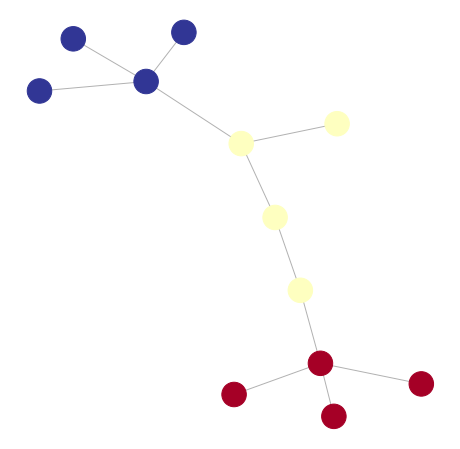

In [127]:
partition = community.best_partition(G)
pos = nx.spring_layout(G)
plt.figure(figsize=(8, 8))
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3)

In [70]:
df_mol.head()

,atom_index,c_closeness,c_degree,c_eigenvector,centrality,community,gdist_to0,gdist_to1,gdist_to10,gdist_to11,gdist_to12,gdist_to13,gdist_to14,gdist_to15,gdist_to16,gdist_to17,gdist_to18,gdist_to19,gdist_to2,gdist_to20,gdist_to21,gdist_to22,gdist_to23,gdist_to24,gdist_to25,gdist_to26,gdist_to27,gdist_to28,gdist_to3,gdist_to4,gdist_to5,gdist_to6,gdist_to7,gdist_to8,gdist_to9,molecule_name
0,0,1.000000,1.00,0.707107,0.457142,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,dsgdb9nsd_000001
1,1,0.571429,0.25,0.353553,0.135714,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,dsgdb9nsd_000001
2,2,0.571429,0.25,0.353553,0.135714,0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,dsgdb9nsd_000001
3,3,0.571429,0.25,0.353553,0.135714,0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,dsgdb9nsd_000001
4,4,0.571429,0.25,0.353553,0.135714,0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,dsgdb9nsd_000001


In [71]:
structures.columns

Index(['molecule_name', 'atom_index', 'atom', 'x', 'y', 'z',
       'electronegativity', 'charge', 'etat', 'masse', 'volume', 'rayon_am',
       'rayon_ac', 'rayon_c', 'rayon_i', 'rayon_vdw', 'fusion',
       'ebulution_min', 'enthalpie_fusion', 'enthalpie_vaporisation',
       'capacite_thermique', 'conductivite_thermique', 'isotopes',
       'isotopes_emeteurs'],
      dtype='object')

In [73]:
structures_ = pd.merge(structures.drop(columns=['atom', 'x', 'y', 'z']), df_mol, how='left',on=['molecule_name', 'atom_index'])

In [74]:
structures_.head()

,molecule_name,atom_index,electronegativity,charge,etat,masse,volume,rayon_am,rayon_ac,rayon_c,rayon_i,rayon_vdw,fusion,ebulution_min,enthalpie_fusion,enthalpie_vaporisation,capacite_thermique,conductivite_thermique,isotopes,isotopes_emeteurs,c_closeness,c_degree,c_eigenvector,centrality,community,gdist_to0,gdist_to1,gdist_to10,gdist_to11,gdist_to12,gdist_to13,gdist_to14,gdist_to15,gdist_to16,gdist_to17,gdist_to18,gdist_to19,gdist_to2,gdist_to20,gdist_to21,gdist_to22,gdist_to23,gdist_to24,gdist_to25,gdist_to26,gdist_to27,gdist_to28,gdist_to3,gdist_to4,gdist_to5,gdist_to6,gdist_to7,gdist_to8,gdist_to9
0,dsgdb9nsd_000001,0,2.55,1.0,1.0,3513.0,3.42,70.0,67.0,77.0,4.0,170.0,3546.9,4826.9,105.00,710.90,0.71,990.00,12.0,3.0,1.000000,1.00,0.707107,0.457142,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,dsgdb9nsd_000001,1,2.20,0.0,0.0,76.0,13.26,25.0,53.0,38.0,-3.0,120.0,-259.1,-252.9,0.12,0.46,14.30,0.18,3.0,0.0,0.571429,0.25,0.353553,0.135714,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN
2,dsgdb9nsd_000001,2,2.20,0.0,0.0,76.0,13.26,25.0,53.0,38.0,-3.0,120.0,-259.1,-252.9,0.12,0.46,14.30,0.18,3.0,0.0,0.571429,0.25,0.353553,0.135714,0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN
3,dsgdb9nsd_000001,3,2.20,0.0,0.0,76.0,13.26,25.0,53.0,38.0,-3.0,120.0,-259.1,-252.9,0.12,0.46,14.30,0.18,3.0,0.0,0.571429,0.25,0.353553,0.135714,0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN
4,dsgdb9nsd_000001,4,2.20,0.0,0.0,76.0,13.26,25.0,53.0,38.0,-3.0,120.0,-259.1,-252.9,0.12,0.46,14.30,0.18,3.0,0.0,0.571429,0.25,0.353553,0.135714,0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN


In [75]:
structures_ = structures_.fillna(0)

In [76]:
structures_.head()

,molecule_name,atom_index,electronegativity,charge,etat,masse,volume,rayon_am,rayon_ac,rayon_c,rayon_i,rayon_vdw,fusion,ebulution_min,enthalpie_fusion,enthalpie_vaporisation,capacite_thermique,conductivite_thermique,isotopes,isotopes_emeteurs,c_closeness,c_degree,c_eigenvector,centrality,community,gdist_to0,gdist_to1,gdist_to10,gdist_to11,gdist_to12,gdist_to13,gdist_to14,gdist_to15,gdist_to16,gdist_to17,gdist_to18,gdist_to19,gdist_to2,gdist_to20,gdist_to21,gdist_to22,gdist_to23,gdist_to24,gdist_to25,gdist_to26,gdist_to27,gdist_to28,gdist_to3,gdist_to4,gdist_to5,gdist_to6,gdist_to7,gdist_to8,gdist_to9
0,dsgdb9nsd_000001,0,2.55,1.0,1.0,3513.0,3.42,70.0,67.0,77.0,4.0,170.0,3546.9,4826.9,105.00,710.90,0.71,990.00,12.0,3.0,1.000000,1.00,0.707107,0.457142,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,dsgdb9nsd_000001,1,2.20,0.0,0.0,76.0,13.26,25.0,53.0,38.0,-3.0,120.0,-259.1,-252.9,0.12,0.46,14.30,0.18,3.0,0.0,0.571429,0.25,0.353553,0.135714,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
2,dsgdb9nsd_000001,2,2.20,0.0,0.0,76.0,13.26,25.0,53.0,38.0,-3.0,120.0,-259.1,-252.9,0.12,0.46,14.30,0.18,3.0,0.0,0.571429,0.25,0.353553,0.135714,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
3,dsgdb9nsd_000001,3,2.20,0.0,0.0,76.0,13.26,25.0,53.0,38.0,-3.0,120.0,-259.1,-252.9,0.12,0.46,14.30,0.18,3.0,0.0,0.571429,0.25,0.353553,0.135714,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,dsgdb9nsd_000001,4,2.20,0.0,0.0,76.0,13.26,25.0,53.0,38.0,-3.0,120.0,-259.1,-252.9,0.12,0.46,14.30,0.18,3.0,0.0,0.571429,0.25,0.353553,0.135714,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
structures_.shape

(2358657, 54)

In [78]:
structures_.to_pickle('graph_feats_structures.pkl', compression='gzip')

In [86]:
_1JHC = train[train['type']=='1JHC']

In [87]:
_1JHC.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant'],
      dtype='object')

In [99]:
del _1JHC

In [85]:
import seaborn as sns

In [91]:
train.type.unique()

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

In [104]:
res = {'1JHN':-1.12, '1JHC':-0.42, '2JHH':-1.88, '2JHN': -1.90, '2JHC':-1.35, '3JHH':-1.90, '3JHC':-1.33, '3JHN':-2.23}

In [105]:
def m_distplot(df, col, n_col=5):
    
    plot_features = df[col].unique().tolist()
        
    n_chart = len(plot_features)
    n_row = int(n_chart/n_col) if n_chart % n_col == 0 else int(n_chart/n_col)+1
        
    fig = plt.figure(figsize=(5*n_col, 3*n_row))
    for i, feat_value in enumerate(plot_features):
        ax = fig.add_subplot(n_row, n_col, i+1)
        sns.distplot(df[df[col]==feat_value]['scalar_coupling_constant'], label=f'{feat_value}-{res[feat_value]}', ax=ax)
        plt.legend()
#         print(feat_value)
    return


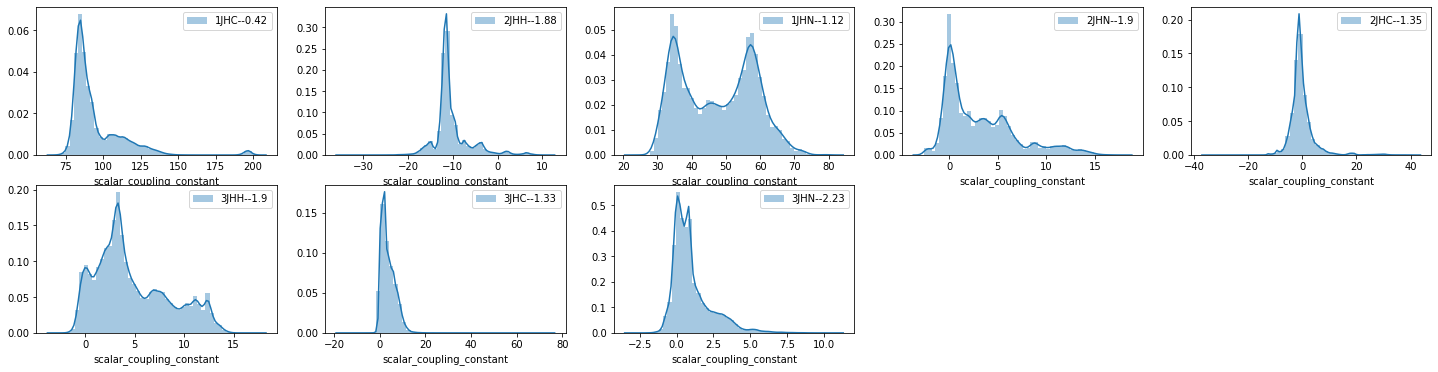

In [106]:
m_distplot(train, 'type')

In [107]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [109]:
{'H':120, 'C':170, 'N':155, 'O':3.44, 'F':3.98 }.keys()

dict_keys(['H', 'C', 'N', 'O', 'F'])

In [111]:
atom_num_count_list = []
for c, g in structures.groupby(by=['molecule_name']):
    
    d_ = {}
    d_['molecule_name'] = c
    d_['atom_count'] = g.shape[0]
    for atom in ['H', 'C', 'N', 'O', 'F']:
        d_[f'{atom}_count'] = g[g['atom']==atom].shape[0]
    
    atom_num_count_list.append(d_)

In [112]:
df_atom_num_count = pd.DataFrame(atom_num_count_list)

In [156]:
df_atom_num_count.head()

,molecule_name,atom_count,H_count,C_count,N_count,O_count,F_count
0,dsgdb9nsd_000001,5,4,1,0,0,0
1,dsgdb9nsd_000002,4,3,0,1,0,0
2,dsgdb9nsd_000003,3,2,0,0,1,0
3,dsgdb9nsd_000004,4,2,2,0,0,0
4,dsgdb9nsd_000005,3,1,1,1,0,0


In [157]:
df_atom_num_count.to_pickle('df_atom_num_count.pkl', compression='gzip')

In [ ]:
'../../molecularproperties/extract_features/distance-is-all-you-need_list_.pickle'

In [114]:
with open('distance-is-all-you-need_list_.pickle', 'rb') as f:
    oof_list_ = pickle.load(f)

In [119]:
oof_list_[0]['oof'].head(5)

,oof_scalar_coupling_constant
id,
0,85.004863
1,-11.306925
2,-11.029535
3,-11.197567
4,84.605554


In [120]:
train = pd.merge(train, oof_list_[0]['oof'], how='left',on=['id'])

In [121]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,oof_scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,85.004863
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,-11.306925
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,-11.029535
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,-11.197567
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,84.605554


In [122]:
train['residual'] = (train['scalar_coupling_constant']-train['oof_scalar_coupling_constant']).abs()

In [123]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,oof_scalar_coupling_constant,residual
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,85.004863,0.197263
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,-11.306925,0.049925
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,-11.029535,0.225265
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,-11.197567,0.056733
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,84.605554,0.201846


In [124]:
train = pd.merge(train, df_atom_num_count, how='left',on=['molecule_name'])

In [125]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,oof_scalar_coupling_constant,residual,atom_count,H_count,C_count,N_count,O_count,F_count
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,85.004863,0.197263,5,4,1,0,0,0
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,-11.306925,0.049925,5,4,1,0,0,0
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,-11.029535,0.225265,5,4,1,0,0,0
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,-11.197567,0.056733,5,4,1,0,0,0
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,84.605554,0.201846,5,4,1,0,0,0


In [151]:
def m_distplot(df, col, n_col=5):
    
    plot_features = df[col].unique().tolist()
    n_chart = len(plot_features)
    n_row = int(n_chart/n_col) if n_chart % n_col == 0 else int(n_chart/n_col)+1
        
    fig = plt.figure(figsize=(5*n_col, 3*n_row))
    for i, feat_value in enumerate(plot_features):
        ax = fig.add_subplot(n_row, n_col, i+1)
        series_ = df[df[col]==feat_value]['residual']
        if series_.shape[0] < 2:
            continue
        sns.distplot(series_, label=f'{feat_value}-{series_.shape[0]}    {np.log(series_.mean()):.2}', ax=ax)
        plt.legend()
#         print(feat_value)
    return


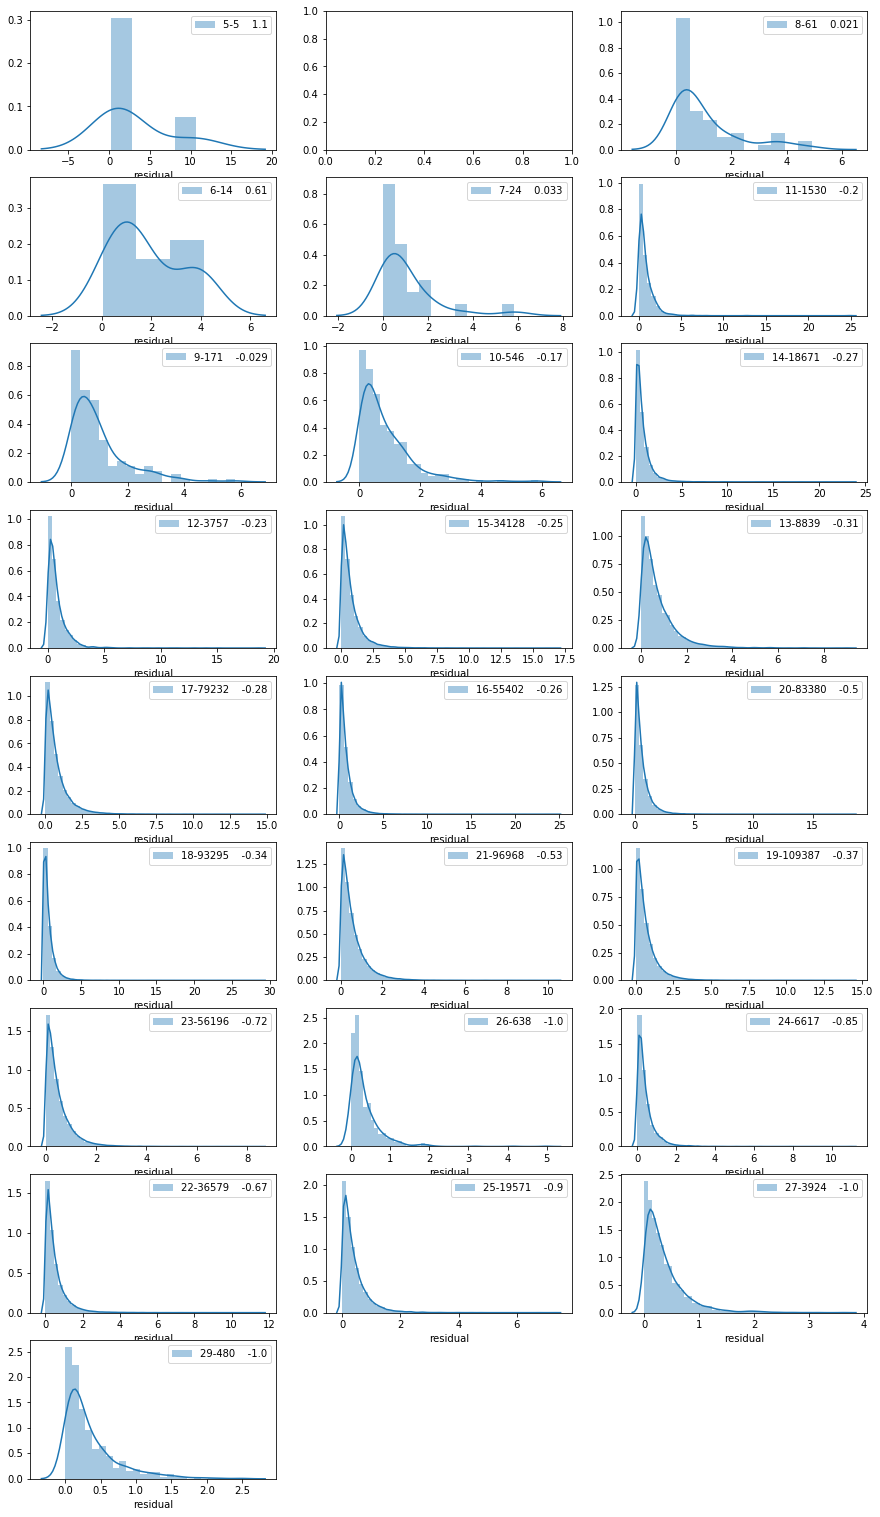

In [152]:
m_distplot(train[train['type']=='1JHC'], 'atom_count', n_col=3)

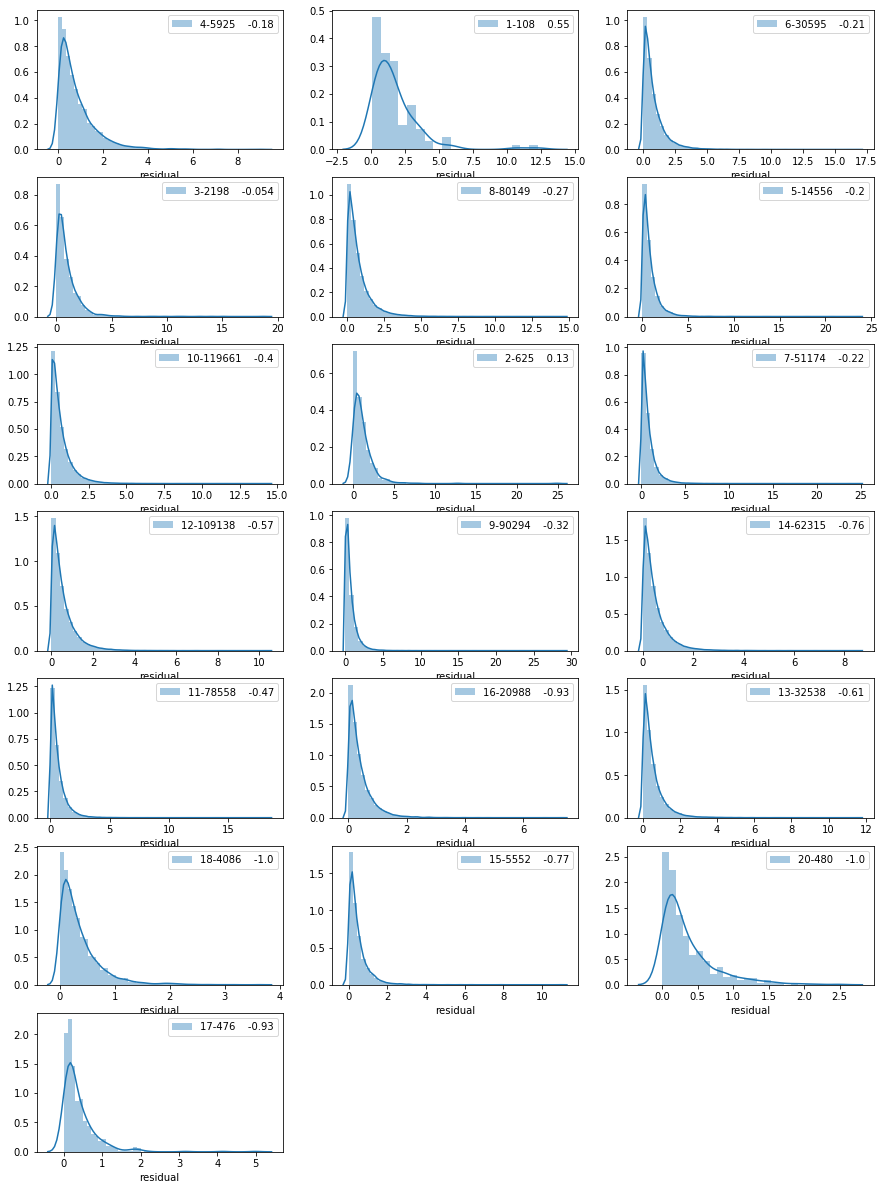

In [153]:
m_distplot(train[train['type']=='1JHC'], 'H_count', n_col=3)

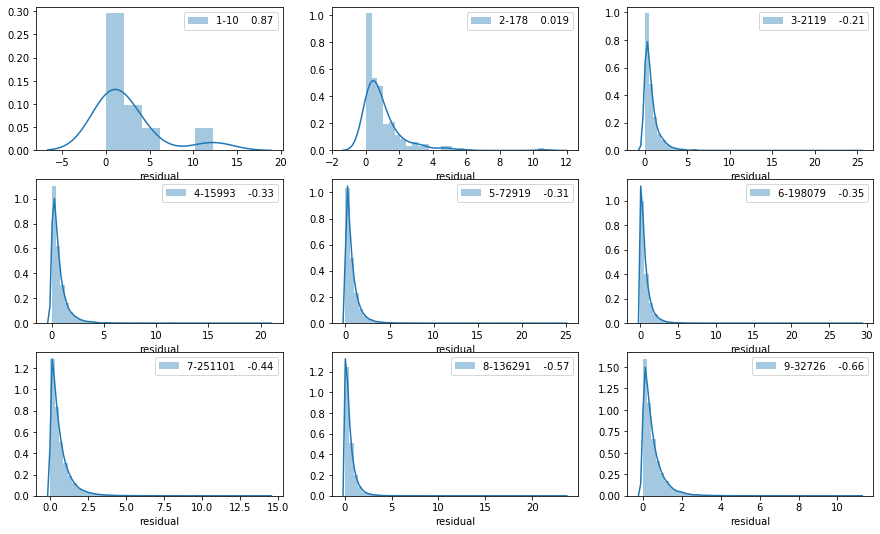

In [154]:
m_distplot(train[train['type']=='1JHC'], 'C_count', n_col=3)

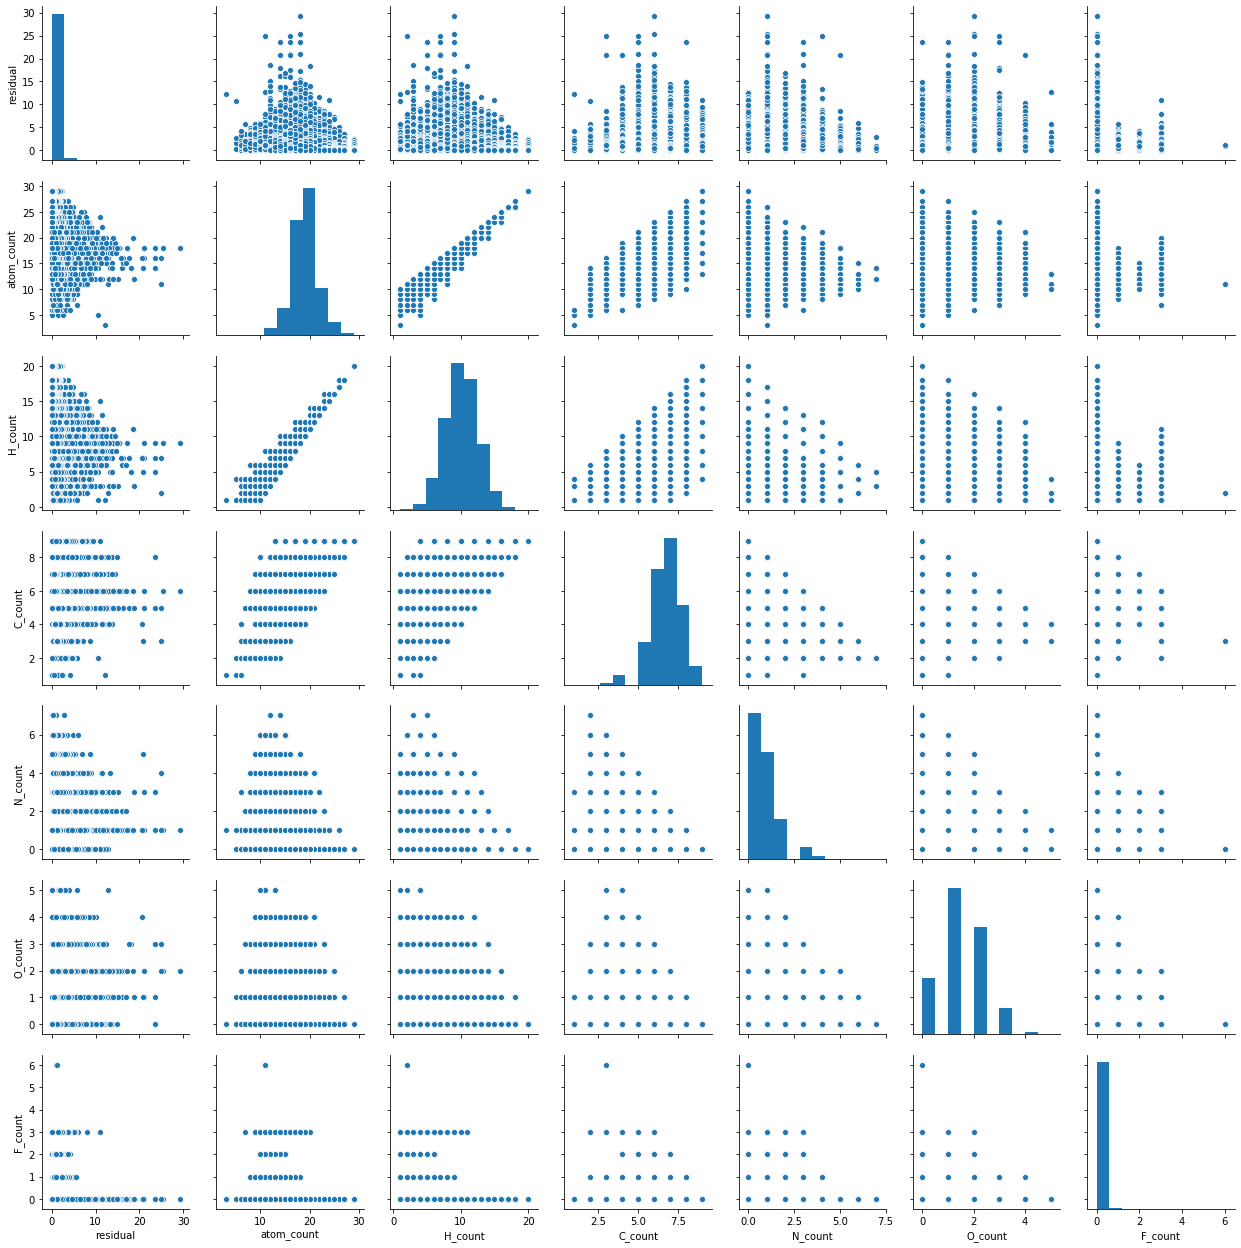

In [155]:
sns.pairplot(train[train['type']=='1JHC'][['residual','atom_count','H_count','C_count','N_count','O_count','F_count']])